# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.


In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#data_dir = '/content/drive/My Drive/Datasets/SEE/Face recognition/data'
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:12<00:00, 4.89kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

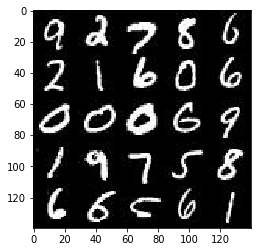

In [0]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

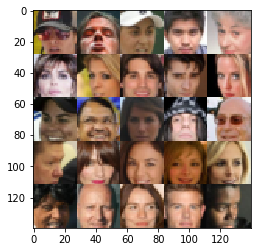

In [0]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.15.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [0]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TO DO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), \
                                       name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    
    return input_real, input_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed



**Leaky ReLU**

In [0]:
def lrelu(x, leak=0.2):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        
        return f1 * x + f2 * abs(x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [0]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        dropout_rate = 0.6
        
        # First conv layer, input 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        drop1 = tf.layers.dropout(x1, rate=dropout_rate)
        relu1 = lrelu(drop1)
        
        # Second conv layer
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        drop2 = tf.layers.dropout(x2, rate=dropout_rate)
        norm2 = tf.layers.batch_normalization(drop2, training=True)
        relu2 = lrelu(norm2)

        # Third conv layer
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        drop3 = tf.layers.dropout(x3, rate=dropout_rate)
        norm3 = tf.layers.batch_normalization(drop3, training=True)
        relu3 = lrelu(norm3)

        # Output layer
        flat = tf.reshape(relu3, (-1, 4*4*512))
        dense = tf.layers.dense(flat, 1024) #, activation=tf.nn.relu)
        dropout = tf.layers.dropout(dense, rate=dropout_rate)
        logits = tf.layers.dense(dropout, 1)
        norm3 = tf.layers.batch_normalization(logits, training=True)
        output = tf.sigmoid(norm3)

    
        return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.Dense instead.
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [0]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TO DO: Implement Function

    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        dropout_rate = 0.3

        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        drop1 = tf.layers.dropout(x1, rate=dropout_rate)
        shape1 = tf.reshape(drop1, (-1, 7, 7, 512))
        norm1 = tf.layers.batch_normalization(shape1, training=is_train)
        relu1 = lrelu(norm1)
        
        # Second conv layer
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        norm2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = lrelu(norm2)
        
        # Third conv layer
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        norm3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = lrelu(norm3)
    
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', \
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        output = tf.tanh(logits)

        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [0]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TO DO: Implement Function
    
    smooth = 0.1
    
    # Generator model
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator models
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_real, \
                                    labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_fake, \
                                    labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                    logits=d_logits_fake, \
                                    labels=tf.ones_like(d_model_fake)))
    
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TO DO: Implement Function
    
    # Get weights and bias update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, \
                                         beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, \
                                         beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    _, image_width, image_height, out_channel_dim = data_shape
    
    # Build Model    
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # batch images
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6949... Generator Loss: 61.9632
Epoch 1/2... Discriminator Loss: 3.3458... Generator Loss: 37.9948
Epoch 1/2... Discriminator Loss: 7.1957... Generator Loss: 1.3536
Epoch 1/2... Discriminator Loss: 20.0720... Generator Loss: 47.9881
Epoch 1/2... Discriminator Loss: 16.8815... Generator Loss: 34.8569
Epoch 1/2... Discriminator Loss: 11.0942... Generator Loss: 0.0870
Epoch 1/2... Discriminator Loss: 3.7430... Generator Loss: 1.4575
Epoch 1/2... Discriminator Loss: 4.4759... Generator Loss: 9.2219
Epoch 1/2... Discriminator Loss: 2.0861... Generator Loss: 7.1061
Epoch 1/2... Discriminator Loss: 3.5365... Generator Loss: 7.4032


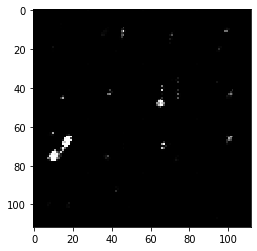

Epoch 1/2... Discriminator Loss: 2.0202... Generator Loss: 4.2912
Epoch 1/2... Discriminator Loss: 1.6062... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 2.7803... Generator Loss: 0.2551
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 1.4528
Epoch 1/2... Discriminator Loss: 1.7918... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 2.0207... Generator Loss: 0.3202
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 2.9865
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.6467


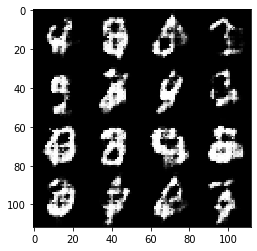

Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 1.6573... Generator Loss: 2.6929
Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 2.4756
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 1.6348
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 1.9756
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 1.3155


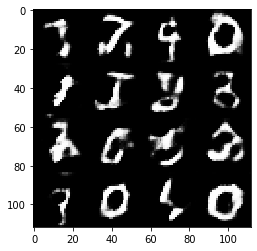

Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 0.8904
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 1.7524
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.1393... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 1.2387
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.5969


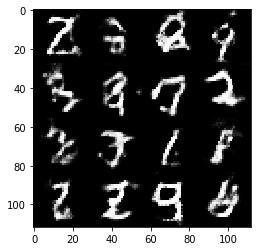

Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 1.0237
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 1.1254
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 1.1415


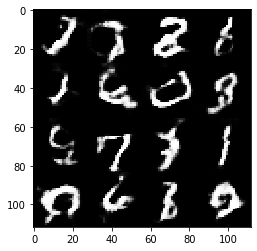

Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.2792
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.0525
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.0950
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.7184
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 1.2281
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 1.3571
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.8753


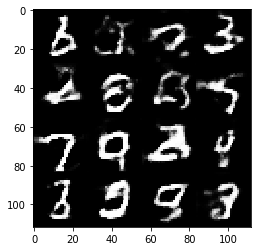

Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 1.0087
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 1.0130
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 1.1345
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.8740
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.8781
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 0.9483


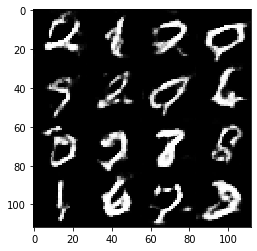

Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 1.1507
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 1.3766
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.8589
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 1.0038


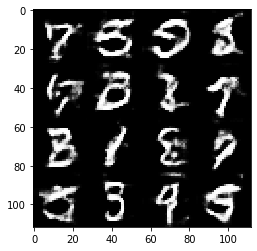

Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.1948... Generator Loss: 1.1272
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 1.0684
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 1.3011
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.9632
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.0101
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.9904


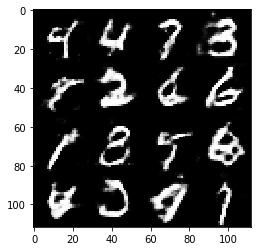

Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.9952
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 1.0813
Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 1.0353
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 1.5407
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 1.0543
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 1.0592


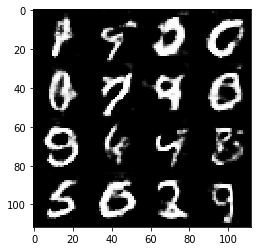

Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.0653
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 1.1908
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 1.0511
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.8520


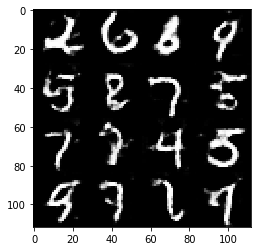

Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 1.1840... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.9337
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 0.9363


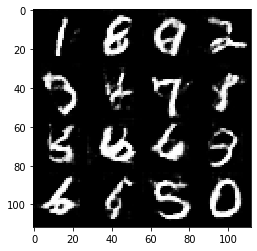

Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 0.8656
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.8626
Epoch 2/2... Discriminator Loss: 1.2295... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.2441... Generator Loss: 0.9264


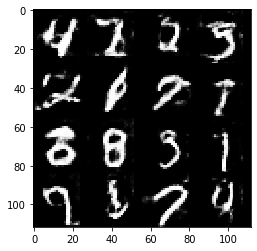

Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 1.0577
Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.9368
Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.9754
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 1.0133


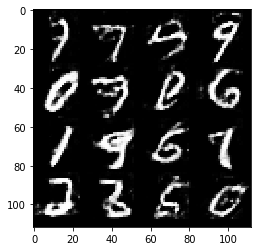

Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.8999
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.9742
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.9393


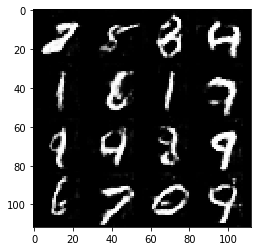

Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.9708
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.8911
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 1.2500... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.8681
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.9068


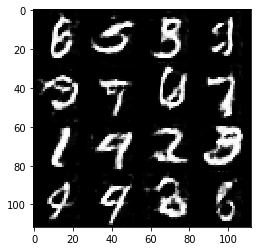

Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.9136
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.8425
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.9054


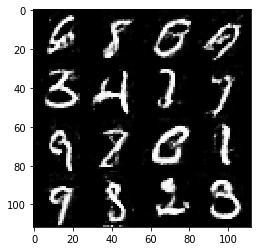

Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 0.9318
Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.8999
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.8713
Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 0.9555
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.8738


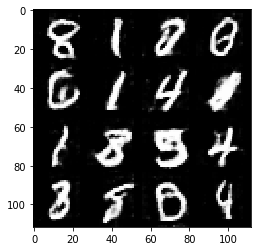

Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.9453
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.9422
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.9302
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.9864


In [0]:
batch_size = 64
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.7943... Generator Loss: 104.2358
Epoch 1/1... Discriminator Loss: 3.5878... Generator Loss: 44.8996
Epoch 1/1... Discriminator Loss: 4.8448... Generator Loss: 13.5406
Epoch 1/1... Discriminator Loss: 5.0514... Generator Loss: 4.7633
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 12.2870
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 13.5687
Epoch 1/1... Discriminator Loss: 5.1045... Generator Loss: 0.1838
Epoch 1/1... Discriminator Loss: 11.8315... Generator Loss: 32.1164
Epoch 1/1... Discriminator Loss: 2.7030... Generator Loss: 2.0982
Epoch 1/1... Discriminator Loss: 1.9959... Generator Loss: 3.4198


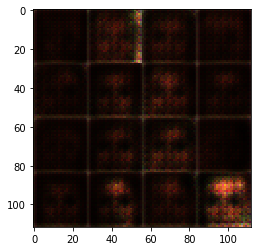

Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 4.1789... Generator Loss: 5.3098
Epoch 1/1... Discriminator Loss: 4.9333... Generator Loss: 7.2949
Epoch 1/1... Discriminator Loss: 2.1537... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 2.2305
Epoch 1/1... Discriminator Loss: 2.1307... Generator Loss: 3.1186
Epoch 1/1... Discriminator Loss: 2.1936... Generator Loss: 3.1264
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 2.1121
Epoch 1/1... Discriminator Loss: 2.5482... Generator Loss: 3.8466
Epoch 1/1... Discriminator Loss: 2.1945... Generator Loss: 2.5788


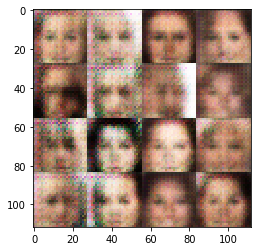

Epoch 1/1... Discriminator Loss: 2.7013... Generator Loss: 4.2603
Epoch 1/1... Discriminator Loss: 2.5475... Generator Loss: 4.5033
Epoch 1/1... Discriminator Loss: 1.9595... Generator Loss: 2.2773
Epoch 1/1... Discriminator Loss: 2.3334... Generator Loss: 3.1119
Epoch 1/1... Discriminator Loss: 2.0037... Generator Loss: 1.9842
Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 1.7824
Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 2.2362
Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 2.1086
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 2.1456... Generator Loss: 1.7643


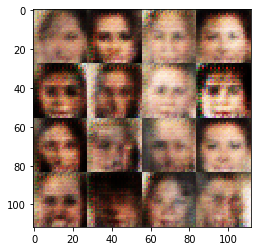

Epoch 1/1... Discriminator Loss: 1.8049... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.8237... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 1.9078
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 1.4321


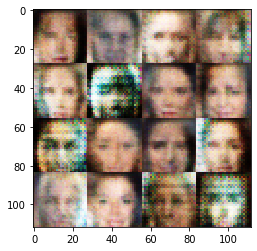

Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 1.6958
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 1.7568
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7907


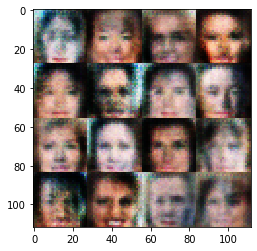

Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.9070


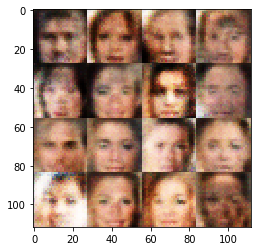

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.1884


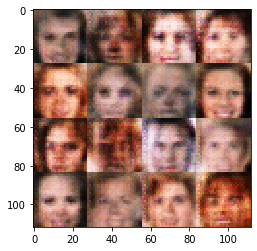

Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 1.0494


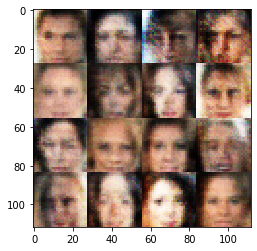

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7399


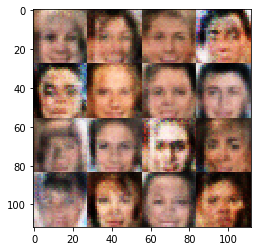

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8328


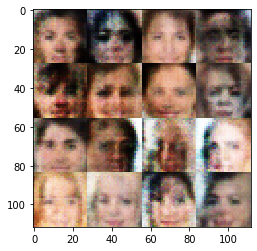

Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8256


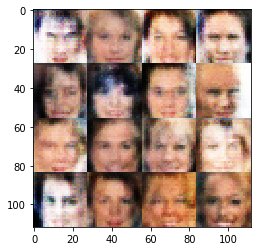

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8080


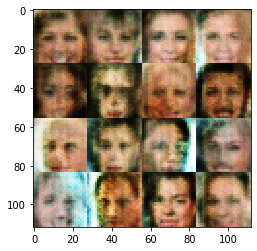

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8609


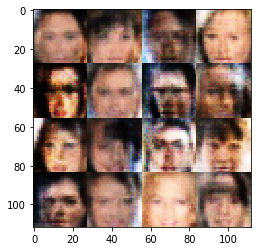

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8319


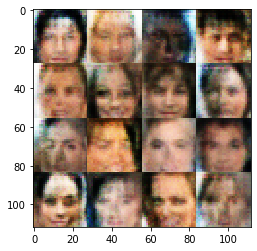

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7248


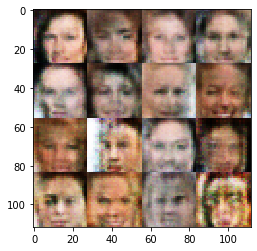

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.9339


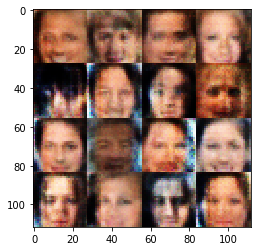

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.9557


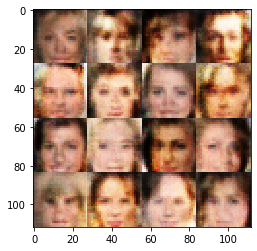

Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8646


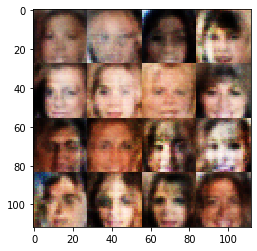

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8883


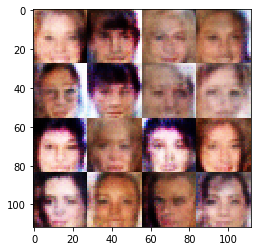

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8145


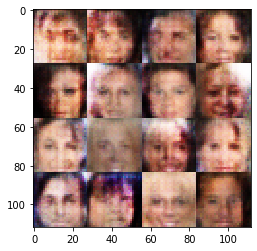

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7978


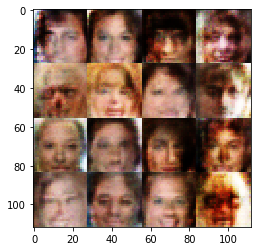

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7834


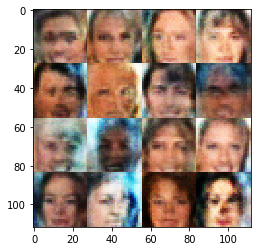

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7750


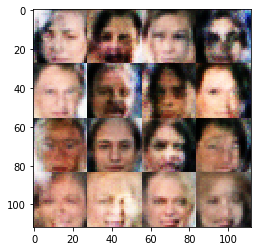

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8194


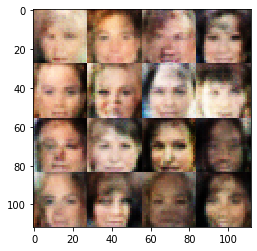

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8452


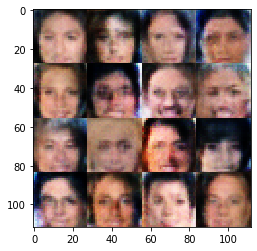

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7976


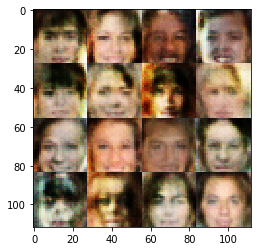

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7874


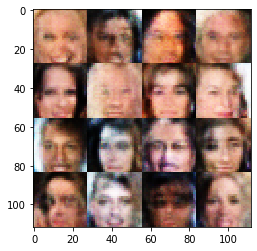

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8114


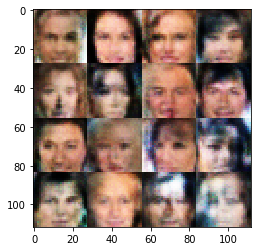

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8000


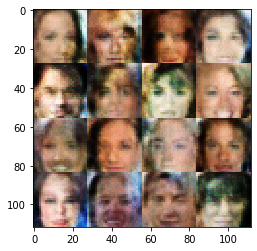

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8084


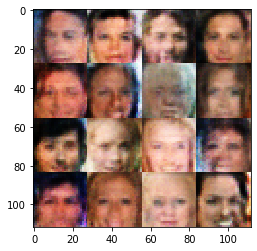

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8005


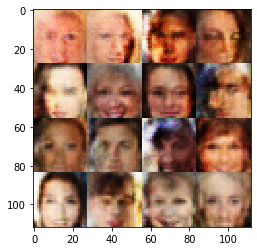

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7918


In [0]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)